In [1]:
import os
import shutil
import pandas as pd
from PIL import Image
import numpy as np
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

img_rows = 224
img_cols = 224
color_type = 3
batch_size=48
epochs=300
subject='Melanoma'
main_path=os.path.join("E:\\kaggle_imgs",subject)
img_path=os.path.join(main_path,"images")
data_path=os.path.join(main_path,"Data")
saved_path=os.path.join(main_path,"saved_models")
paths=[main_path, img_path,saved_path,data_path]
for fp in paths:
    print(fp)
    if not os.path.exists(fp):        
        os.mkdir(fp)
file_path=os.path.join(saved_path,"200621_")
file_best=os.path.join(saved_path,"200621__epoch_ 0_acc_92.00")

train_img_pkl=os.path.join(data_path,"train_imgs.npy")
test_img_pkl=os.path.join(data_path,"test_imgs.npy")
train_info_pkl=os.path.join(data_path,"df_train_pickle.csv")

num_classes=4

E:\kaggle_imgs\Melanoma
E:\kaggle_imgs\Melanoma\images
E:\kaggle_imgs\Melanoma\saved_models
E:\kaggle_imgs\Melanoma\Data


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

## Load train Data


In [4]:
def read_train_info():
    fp=train_info_pkl
    if False and os.path.exists(fp):
        try:
            print('loading train data from csv', flush=True)
            df_train=pd.read_csv(fp)
            print('complete!', flush=True)
        except EOFError:
            print('EOFError raised.', flush=True)
        
    else:
        df_train=pd.read_csv(data_path+"/train.csv")
        X=df_train['image_name'].values
        y=df_train['target'].values
        skf=StratifiedKFold(n_splits=5,random_state=22)        
        df_train["fold"]=-1
        sum=0
        for i, (trn_idx,val_idx) in enumerate(skf.split(X,y)):
            df_train.loc[val_idx,"fold"]=i
        df_train.to_csv(train_info_pkl,index=False)
        
    return df_train

df_train=read_train_info()
df_test = pd.read_csv(os.path.join(data_path,"test.csv"))

## Augmentation

In [5]:
# import torchvision.transforms as transforms

# transform_train = transforms.Compose([
# #    transforms.RandomCrop(32, padding=4),
#     transforms.Resize((img_rows,img_cols),interpolation=Image.NEAREST),
#     transforms.ToTensor(),
#     transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
# ])

# transform_valid = transforms.Compose([
#     transforms.Resize((img_rows,img_cols),interpolation=Image.NEAREST),
#     transforms.ToTensor(),
#     transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
# ])
# invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
#                                                      std = [ 1/0.5, 1/0.5, 1/0.5 ]),
#                                 transforms.Normalize(mean = [ -0.5, -0.5, -0.5 ],
#                                                      std = [ 1., 1., 1. ]),
#                                ])

In [6]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, Rotate, Cutout, VerticalFlip, Normalize
)
from albumentations.pytorch import ToTensor

train_transforms= Compose([
    Rotate(15),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
    Normalize(),
    ToTensor()
])
valid_transforms=Compose([
    Normalize(),
    ToTensor()
])

## Advanced Aug

In [7]:
class AdvancedHairAugmentation:
    """
    Impose an image of a hair to the target image

    Args:
        hairs (int): maximum number of hairs to impose
        hairs_folder (str): path to the folder with hairs images
    """

    def __init__(self, hairs: int = 5, hairs_folder: str = ""):
        self.hairs = hairs
        self.hairs_folder = hairs_folder

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to draw hairs on.

        Returns:
            PIL Image: Image with drawn hairs.
        """
        n_hairs = random.randint(0, self.hairs)
        
        if not n_hairs:
            return img
        
        height, width, _ = img.shape  # target image width and height
        hair_images = [im for im in os.listdir(self.hairs_folder) if 'png' in im]
        
        for _ in range(n_hairs):
            hair = cv2.imread(os.path.join(self.hairs_folder, random.choice(hair_images)))
            hair = cv2.flip(hair, random.choice([-1, 0, 1]))
            hair = cv2.rotate(hair, random.choice([0, 1, 2]))

            h_height, h_width, _ = hair.shape  # hair image width and height
            roi_ho = random.randint(0, img.shape[0] - hair.shape[0])
            roi_wo = random.randint(0, img.shape[1] - hair.shape[1])
            roi = img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            # Creating a mask and inverse mask
            img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)

            # Now black-out the area of hair in ROI
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

            # Take only region of hair from hair image.
            hair_fg = cv2.bitwise_and(hair, hair, mask=mask)

            # Put hair in ROI and modify the target image
            dst = cv2.add(img_bg, hair_fg)

            img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst
                
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(hairs={self.hairs}, hairs_folder="{self.hairs_folder}")'

In [8]:
class Microscope:
    """
    Cutting out the edges around the center circle of the image
    Imitating a picture, taken through the microscope

    Args:
        p (float): probability of applying an augmentation
    """

    def __init__(self, p: float = 0.5):
        self.p = p

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to apply transformation to.

        Returns:
            PIL Image: Image with transformation.
        """
        if random.random() < self.p:
            circle = cv2.circle((np.ones(img.shape) * 255).astype(np.uint8), # image placeholder
                        (img.shape[0]//2, img.shape[1]//2), # center point of circle
                        random.randint(img.shape[0]//2 - 3, img.shape[0]//2 + 15), # radius
                        (0, 0, 0), # color
                        -1)

            mask = circle - 255
            img = np.multiply(img, mask)
        
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(p={self.p})'

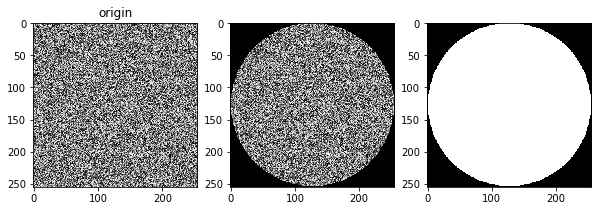

In [9]:
## My Test

img=np.random.randint(0,256,(255,255))
circle = cv2.circle((np.ones(img.shape) * 255).astype(np.uint8), # image placeholder
            (img.shape[0]//2, img.shape[1]//2), # center point of circle
            np.random.randint(img.shape[0]//2 - 3, img.shape[0]//2 + 15), # radius
            (0, 0, 0), # color
            -1)
mask = circle - 255
img2 = np.multiply(img, mask)

f,ax=plt.subplots(1,3,figsize=(10,6))
ax[0].imshow(img,cmap="gray"),ax[0].set_title("origin")
ax[1].imshow(img2,cmap="gray")
ax[2].imshow(mask,cmap="gray")

## Dataset

In [10]:
df_train

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,fold
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,0
...,...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0,4
33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0,4
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0,4
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0,4


In [11]:
from torch.utils.data import Dataset
from PIL import Image
class PlantDataset(Dataset):
    def __init__(self, df, tr=None):
        self.df = df
        self.tr=tr
        
    def __len__(self):
        return self.df.shape[0]
    def __getitem__(self, idx):
        name=self.df.iloc[idx].image_name
        image_src=img_path+"/train/"+name+".jpg"
        img = Image.open(image_src)
        img=np.array(img.resize((img_cols,img_rows)))
        labels = self.df.iloc[idx].target

        if self.tr is not None:
            img=self.tr(image=img)["image"]
        
        return img, labels

## transforms and normalization

In [12]:
def get_images_by_fold(fold):
    sel=fold
    trn_fold=[i for i in range(5) if i not in [sel]]
    val_fold=[i for i in range(5) if i in [sel]]
    trn_idx=df_train[df_train.fold.isin(trn_fold)].index
    val_idx=df_train[df_train.fold.isin(val_fold)].index
    trainset = PlantDataset(df=df_train.loc[trn_idx],
                           tr=train_transforms)
    validset =PlantDataset(df=df_train.loc[val_idx],
                          tr=valid_transforms)

    train_loader = torch.utils.data.DataLoader(trainset,
                                              batch_size=batch_size,
                                              shuffle=True, num_workers=0)
    valid_loader = torch.utils.data.DataLoader(validset,
                                              batch_size=batch_size,
                                              shuffle=False, num_workers=0)
    return train_loader,valid_loader

In [13]:
train_loader,valid_loader=get_images_by_fold(0)

In [14]:
for img,lab in train_loader:
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


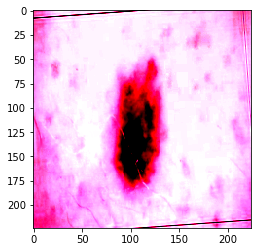

In [15]:
plt.imshow(img[0].permute(1,2,0))

## Model

In [16]:
import torchvision.models as models

In [17]:
resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
num_ftrs = resnext50_32x4d.fc.in_features
resnext50_32x4d.fc = nn.Linear(num_ftrs, 2)

In [18]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [19]:
resnext50_32x4d

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [20]:
resnext50_32x4d=resnext50_32x4d.to(device)

In [21]:
a=torch.Tensor(1,3,img_rows,img_cols).to(device)
out = resnext50_32x4d(a)
print(out)

tensor([[ 0.2616, -0.1338]], device='cuda:0', grad_fn=<AddmmBackward>)


In [22]:
criterion=nn.CrossEntropyLoss().to(device)
optimizer=torch.optim.SGD(resnext50_32x4d.parameters(),lr=1e-2,momentum=0.9,weight_decay=5e-4)
lr_sched=optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.5)

## define acc check func

In [23]:
best_acc=90
REF_OPT=True
cur_best=file_best
def acc_check(net, test_set, epoch, save=1):
    correct = 0
    total = 0
    global best_acc
    global cur_best
    with torch.no_grad():
        for data in test_set:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    acc = (100 * correct / total)
    print('Accuracy of the network on the 10000 test images: %d %%' % acc)
    if save and best_acc<acc:
        best_acc=acc
        bf=file_path+"_epoch_%2d_acc_%.2f.pth"%(epoch, acc)
        state = {
        'epoch': epoch,
        'state_dict': resnext50_32x4d.state_dict(),
        'optimizer': optimizer.state_dict(),
        }
        torch.save(state, bf)
        cur_best=bf
    elif REF_OPT and best_acc -3 > acc :
        if os.path.isfile(cur_best):
            checkpoint = torch.load(cur_best)
            resnext50_32x4d.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            epoch = checkpoint['epoch']
            print("Load Complete",cur_best)

    return acc


In [24]:
 if os.path.isfile(file_best):
    checkpoint = torch.load(file_best)
    resnext50_32x4d.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    print("Load Complete",cur_best)

In [25]:
print(len(train_loader))

553


In [27]:

print(len(train_loader))
epochs = 5

for epoch in range(epochs):  # loop over the dataset multiple times
    
    running_loss = 0.0
    lr_sched.step()
    
    for my_iter in range(5):
        train_loader,valid_loader=get_images_by_fold(my_iter)
        print("iter %d/5 load complete"%my_iter)
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = resnext50_32x4d(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if (i +1)% 10 ==0:    # print every 30 mini-batches
#                value_tracker(loss_plt, torch.Tensor([running_loss/30]), torch.Tensor([i + epoch*len(train_loader) ]))
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 30))
                running_loss = 0.0
    
        #Check Accuracy
        acc = acc_check(resnext50_32x4d, valid_loader, epoch, save=1)
    #    value_tracker(acc_plt, torch.Tensor([acc]), torch.Tensor([epoch]))
    

print('Finished Training')

553
iter 0/5 load complete
[1,    10] loss: 0.034


KeyboardInterrupt: 

In [ ]:
np.random.randint(0,5)

In [ ]:
a

In [ ]:
aaa

In [ ]:
class Net(nn.Module):
    def __init__(self, arch, n_meta_features: int):
        super(Net, self).__init__()
        self.arch = arch
        if 'ResNet' in str(arch.__class__):
            self.arch.fc = nn.Linear(in_features=512, out_features=500, bias=True)
        if 'EfficientNet' in str(arch.__class__):
            self.arch._fc = nn.Linear(in_features=1280, out_features=500, bias=True)
        self.meta = nn.Sequential(nn.Linear(n_meta_features, 500),
                                  nn.BatchNorm1d(500),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2),
                                  nn.Linear(500, 250),  # FC layer output will have 250 features
                                  nn.BatchNorm1d(250),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2))
        self.ouput = nn.Linear(500 + 250, 1)
        
    def forward(self, inputs):
        """
        No sigmoid in forward because we are going to use BCEWithLogitsLoss
        Which applies sigmoid for us when calculating a loss
        """
        x, meta = inputs
        cnn_features = self.arch(x)
        meta_features = self.meta(meta)
        features = torch.cat((cnn_features, meta_features), dim=1)
        output = self.ouput(features)
        return output

In [ ]:
arch = EfficientNet.from_pretrained('efficientnet-b1')  # Going to use efficientnet-b1 NN architecture
# skf = StratifiedKFold(n_splits=5, random_state=999, shuffle=True)
skf = GroupKFold(n_splits=5)

In [ ]:
test = MelanomaDataset(df=test_df,
                       imfolder='/kaggle/input/melanoma-external-malignant-256/test/test/', 
                       train=False,
                       transforms=train_transform,
                       meta_features=meta_features)

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 10  # Number of epochs to run
model_path = 'model.pth'  # Path and filename to save model to
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds

oof = np.zeros((len(train_df), 1))  # Out Of Fold predictions
preds = torch.zeros((len(test), 1), dtype=torch.float32, device=device)  # Predictions for test test

In [ ]:
def get_split_data(train_idx,val_idx):
    train = MelanomaDataset(df=train_df.iloc[train_idx].reset_index(drop=True), \
                            imfolder=img_path+"/jpeg/train/", 
                            train=True, 
                            transforms=train_transform,
                            meta_features=meta_features)
    val = MelanomaDataset(df=train_df.iloc[val_idx].reset_index(drop=True), 
                          imfolder=img_path+"/jpeg/train/", 
                          train=True, 
                          transforms=test_transform,
                          meta_features=meta_features)
    
    train_loader = DataLoader(dataset=train, batch_size=64, shuffle=True, num_workers=0)
    val_loader = DataLoader(dataset=val, batch_size=16, shuffle=False, num_workers=0)
    test_loader = DataLoader(dataset=test, batch_size=16, shuffle=False, num_workers=0)
    
    return train_loader,val_loader,test_loader


In [ ]:
X=np.zeros(len(train_df))
y=train_df['target']
for fold, (train_idx, val_idx) in enumerate(skf.split(X,y, groups=train_df['patient_id'].tolist()), 1):
    break

train_loader,val_loader,test_loader=get_split_data(train_idx, val_idx)

In [ ]:
for img,lab in train_loader:
    break

In [ ]:
# We stratify by target value, thus, according to sklearn StratifiedKFold documentation
# We can fill `X` with zeroes of corresponding length to use it as a placeholder
# since we only need `y` to stratify the data
# for fold, (train_idx, val_idx) in enumerate(skf.split(X=np.zeros(len(train_df)), y=train_df['target']), 1):
X=np.zeros(len(train_df))
y=train_df['target']
for fold, (train_idx, val_idx) in enumerate(skf.split(X,y, groups=train_df['patient_id'].tolist()), 1):
    print('=' * 20, 'Fold', fold, '=' * 20)
    
    best_val = None  # Best validation score within this fold
    patience = es_patience  # Current patience counter
    arch = EfficientNet.from_pretrained('efficientnet-b1')
    model = Net(arch=arch, n_meta_features=len(meta_features))  # New model for each fold
    model = model.to(device)

    optim = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer=optim, mode='max', patience=1, verbose=True, factor=0.2)
    criterion = nn.BCEWithLogitsLoss()
    
    train_loader,val_loader,test_loader =  get_split_data(train_idx,val_idx)
    
    for epoch in range(epochs):
        start_time = time.time()
        correct = 0
        epoch_loss = 0
        model.train()
        
        for x, y in train_loader:
            x[0] = torch.tensor(x[0], device=device, dtype=torch.float32)
            x[1] = torch.tensor(x[1], device=device, dtype=torch.float32)
            y = torch.tensor(y, device=device, dtype=torch.float32)
            optim.zero_grad()
            z = model(x)
            loss = criterion(z, y.unsqueeze(1))
            loss.backward()
            optim.step()
            pred = torch.round(torch.sigmoid(z))  # round off sigmoid to obtain predictions
            correct += (pred.cpu() == y.cpu().unsqueeze(1)).sum().item()  # tracking number of correctly predicted samples
            epoch_loss += loss.item()
        train_acc = correct / len(train_idx)

        model.eval()  # switch model to the evaluation mode
        val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
        with torch.no_grad():  # Do not calculate gradient since we are only predicting
            # Predicting on validation set
            for j, (x_val, y_val) in enumerate(val_loader):
                x_val[0] = torch.tensor(x_val[0], device=device, dtype=torch.float32)
                x_val[1] = torch.tensor(x_val[1], device=device, dtype=torch.float32)
                y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
                z_val = model(x_val)
                val_pred = torch.sigmoid(z_val)
                val_preds[j*x_val[0].shape[0]:j*x_val[0].shape[0] + x_val[0].shape[0]] = val_pred
            val_acc = accuracy_score(train_df.iloc[val_idx]['target'].values, torch.round(val_preds.cpu()))
            val_roc = roc_auc_score(train_df.iloc[val_idx]['target'].values, val_preds.cpu())
            
            print('Epoch {:03}: | Loss: {:.3f} | Train acc: {:.3f} | Val acc: {:.3f} | Val roc_auc: {:.3f} | Training time: {}'.format(
            epoch + 1, 
            epoch_loss, 
            train_acc, 
            val_acc, 
            val_roc, 
            str(datetime.timedelta(seconds=time.time() - start_time))[:7]))
            
            scheduler.step(val_roc)
            # During the first iteration (first epoch) best validation is set to None
            if not best_val:
                best_val = val_roc  # So any validation roc_auc we have is the best one for now
                torch.save(model, model_path)  # Saving the model
                continue
                
            if val_roc >= best_val:
                best_val = val_roc
                patience = es_patience  # Resetting patience since we have new best validation accuracy
                torch.save(model, model_path)  # Saving current best model
            else:
                patience -= 1
                if patience == 0:
                    print('Early stopping. Best Val roc_auc: {:.3f}'.format(best_val))
                    break
                
    model = torch.load(model_path)  # Loading best model of this fold
    model.eval()  # switch model to the evaluation mode
    val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
    with torch.no_grad():
        # Predicting on validation set once again to obtain data for OOF
        for j, (x_val, y_val) in enumerate(val_loader):
            x_val[0] = torch.tensor(x_val[0], device=device, dtype=torch.float32)
            x_val[1] = torch.tensor(x_val[1], device=device, dtype=torch.float32)
            y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
            z_val = model(x_val)
            val_pred = torch.sigmoid(z_val)
            val_preds[j*x_val[0].shape[0]:j*x_val[0].shape[0] + x_val[0].shape[0]] = val_pred
        oof[val_idx] = val_preds.cpu().numpy()
        
        # Predicting on test set
        for _ in range(TTA):
            for i, x_test in enumerate(test_loader):
                x_test[0] = torch.tensor(x_test[0], device=device, dtype=torch.float32)
                x_test[1] = torch.tensor(x_test[1], device=device, dtype=torch.float32)
                z_test = model(x_test)
                z_test = torch.sigmoid(z_test)
                preds[i*x_test[0].shape[0]:i*x_test[0].shape[0] + x_test[0].shape[0]] += z_test
        preds /= TTA
        
    del train, val, train_loader, val_loader, x, y, x_val, y_val
    gc.collect()
    
preds /= skf.n_splits

## define value tracker

In [ ]:
def value_tracker(value_plot, value, num):
    '''num, loss_value, are Tensor'''
    vis.line(X=num,
             Y=value,
             win = value_plot,
             update='append'
             )

## Load train data

In [ ]:
def read_train_info():
    fp=train_info_pkl
    if False and os.path.exists(fp):
        try:
            print('loading train data from csv', flush=True)
            df_train=pd.read_csv(fp)
            print('complete!', flush=True)
        except EOFError:
            print('EOFError raised.', flush=True)
        
    else:
        df_train=pd.read_csv(data_path+"/train.csv")
        df_train["CAT"]=df_train[['healthy', 'multiple_diseases', 'rust','scab']].values.argmax(axis=1)
        df_train["id"]=df_train["image_id"].apply(lambda x : int(x.split("_")[1]))        
        X=df_train['id'].values
        y=df_train['CAT'].values
        skf=StratifiedKFold(n_splits=5,random_state=22)        
        df_train["fold"]=-1
        sum=0
        for i, (trn_idx,vld_idx) in enumerate(skf.split(X,y)):
            df_train.loc[vld_idx,"fold"]=i
        df_train.to_csv(train_info_pkl,index=False)
        
    return df_train

df_train=read_train_info()


## Augmentation

In [ ]:
import torchvision.transforms as transforms

transform_train = transforms.Compose([
#    transforms.RandomCrop(32, padding=4),
    transforms.Resize((img_rows,img_cols),interpolation=Image.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

transform_valid = transforms.Compose([
    transforms.Resize((img_rows,img_cols),interpolation=Image.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.5, 1/0.5, 1/0.5 ]),
                                transforms.Normalize(mean = [ -0.5, -0.5, -0.5 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, Rotate, Cutout, HorizontalFlip, Normalize
)
from albumentations.pytorch import ToTensor, ToTensorV2
transform_train= Compose([
    Rotate(20),
    ToTensor()
])
transform_valid=Compose([
    ToTensor()
])

## Dataset

In [ ]:
from torch.utils.data import Dataset
class PlantDataset(Dataset):
    def __init__(self, df, tr=None):
        self.df = df
        self.tr=tr
        
    def __len__(self):
        return self.df.shape[0]
    def __getitem__(self, idx):
        name=self.df.iloc[idx].image_id
        image_src=img_path+"/"+name+".jpg"
        image = Image.open(image_src)
        labels = self.df.iloc[idx].CAT

        if self.tr is not None:
            image=self.tr(image)
        
        return image, labels

## transforms and normalization

In [ ]:
sel=1
trn_fold=[i for i in range(5) if i not in [sel]]
val_fold=[i for i in range(5) if i in [sel]]
trn_idx=df_train[df_train.fold.isin(trn_fold)].index
val_idx=df_train[df_train.fold.isin(val_fold)].index
print(trn_idx.shape,val_idx.shape)

In [ ]:
trainset = PlantDataset(df=df_train.loc[trn_idx],
                       tr=transform_train)
validset =PlantDataset(df=df_train.loc[val_idx],
                      tr=transform_valid)

train_loader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(validset,
                                          batch_size=batch_size,
                                          shuffle=False, num_workers=0)

In [ ]:
for img,lab in train_loader:
    break

In [ ]:
plt.imshow(img[0].permute(1,2,0))

## Model

In [ ]:
# import torchvision.models.resnet as resnet

In [ ]:
# conv1x1=resnet.conv1x1
# Bottleneck = resnet.Bottleneck
# BasicBlock= resnet.BasicBlock

In [ ]:
# class ResNet(nn.Module):

#     def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
#         super(ResNet, self).__init__()
#         self.inplanes = 16
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1,
#                                bias=False)
#         self.bn1 = nn.BatchNorm2d(16)
#         self.relu = nn.ReLU(inplace=True)
#         #self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
#         self.layer1 = self._make_layer(block, 16, layers[0], stride=1)
#         self.layer2 = self._make_layer(block, 32, layers[1], stride=1)
#         self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
#         self.layer4 = self._make_layer(block, 128, layers[3], stride=2)
        
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(128 * block.expansion, num_classes)

#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)

#         # Zero-initialize the last BN in each residual branch,
#         # so that the residual branch starts with zeros, and each residual block behaves like an identity.
#         # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
#         if zero_init_residual:
#             for m in self.modules():
#                 if isinstance(m, Bottleneck):
#                     nn.init.constant_(m.bn3.weight, 0)
#                 elif isinstance(m, BasicBlock):
#                     nn.init.constant_(m.bn2.weight, 0)

#     def _make_layer(self, block, planes, blocks, stride=1):
#         downsample = None
#         if stride != 1 or self.inplanes != planes * block.expansion:
#             downsample = nn.Sequential(
#                 conv1x1(self.inplanes, planes * block.expansion, stride),
#                 nn.BatchNorm2d(planes * block.expansion),
#             )

#         layers = []
#         layers.append(block(self.inplanes, planes, stride, downsample))
#         self.inplanes = planes * block.expansion
#         for _ in range(1, blocks):
#             layers.append(block(self.inplanes, planes))

#         return nn.Sequential(*layers)

#     def forward(self, x):
#         #[-1,3,32,32]
#         x = self.conv1(x)
#         #x.shape =[1, 16, 32,32]
#         x = self.bn1(x)
#         x = self.relu(x)
#         #x = self.maxpool(x)

#         x = self.layer1(x)
#         #x.shape =[1, 128, 32,32]
#         x = self.layer2(x)
#         #x.shape =[1, 256, 32,32]
#         x = self.layer3(x)
#         #x.shape =[1, 512, 16,16]
#         x = self.layer4(x)
#         #x.shape =[1, 1024, 8,8]
        
#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)

#         return x

In [ ]:
import torchvision.models  as models
import torch.nn as nn

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'
resnet34 = models.resnet34(pretrained=True)
num_ftrs=resnet34.fc.in_features
resnet34.fc=nn.Linear(num_ftrs,num_classes)

In [ ]:
resnet34=resnet34.to(device)

In [ ]:
a=torch.Tensor(1,3,img_rows,img_cols).to(device)
out = resnet34(a)
print(out)

In [ ]:
criterion=nn.CrossEntropyLoss().to(device)
optimizer=torch.optim.SGD(resnet34.parameters(),lr=1e-2,momentum=0.9,weight_decay=5e-4)
lr_sched=optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.5)

## make plot

In [ ]:
loss_plt = vis.line(Y=torch.Tensor(1).zero_(),
                    opts=dict(title='loss_tracker', 
                              legend=['loss'], 
                              showlegend=True))
acc_plt = vis.line(Y=torch.Tensor(1).zero_(),
                   opts=dict(title='Accuracy', 
                             legend=['Acc'],
                             showlegend=True))

## define acc check func

In [ ]:
best_acc=0
def acc_check(net, test_set, epoch, save=1):
    correct = 0
    total = 0
    global best_acc
    with torch.no_grad():
        for data in test_set:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    acc = (100 * correct / total)
    print('Accuracy of the network on the 10000 test images: %d %%' % acc)
    if save and best_acc<acc:
        best_acc=acc
        torch.save(net.state_dict(), file_path+"_epoch_{}_acc_{}.pth".format(epoch, int(acc)))
    return acc

## train

In [ ]:

print(len(train_loader))
epochs = 10

for epoch in range(epochs):  # loop over the dataset multiple times
    
    running_loss = 0.0
    lr_sched.step()
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet34(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 30 == 29:    # print every 30 mini-batches
            value_tracker(loss_plt, torch.Tensor([running_loss/30]), torch.Tensor([i + epoch*len(train_loader) ]))
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 30))
            running_loss = 0.0
    
    #Check Accuracy
    acc = acc_check(resnet34, valid_loader, epoch, save=1)
    value_tracker(acc_plt, torch.Tensor([acc]), torch.Tensor([epoch]))
    

print('Finished Training')

In [ ]:
print(len(train_loader))

In [ ]:
torch.cuda.current_stream()

In [ ]:
torch.cuda.device_count()

In [ ]:
torch.cuda.empty_cache()